Problem Objective:
The project aims at building a model of housing prices to predict median house values in California using the provided dataset. This model should learn from the data and be able to predict the median housing price in any district, given all the other metrics.

Districts or block groups are the smallest geographical units for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). There are 20,640 districts in the project dataset.

In [3]:
print('Hello World')

Hello World


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import StandardScaler,RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib

In [5]:
#file_path = 'cali-housing data'
california_house_data = pd.read_csv('cali-housing.csv')
california_house_data.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200


In [6]:
california_house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
 9   median_house_value  20640 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


Since we have #total_bedrooms with missing numbers, and #ocean_proximity as the only categorical data there.

In [7]:
california_house_data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
median_house_value      0
dtype: int64

In [8]:
california_house_data.longitude.unique()

array([-122.23, -122.22, -122.24, -122.25, -122.26, -122.27, -122.28,
       -122.29, -122.3 , -122.21, -122.2 , -122.19, -122.18, -122.13,
       -122.16, -122.17, -122.15, -122.14, -122.12, -122.33, -122.34,
       -122.06, -122.07, -122.08, -122.09, -122.1 , -122.11, -122.03,
       -121.97, -122.02, -122.04, -122.05, -121.99, -122.01, -121.96,
       -121.98, -122.  , -121.93, -121.94, -121.95, -121.92, -121.89,
       -121.91, -121.9 , -121.88, -121.87, -121.85, -121.86, -121.84,
       -121.82, -121.77, -121.62, -121.61, -121.72, -121.73, -121.75,
       -121.8 , -121.76, -121.78, -121.79, -119.78, -119.93, -120.  ,
       -120.56, -120.59, -120.55, -120.25, -120.79, -120.8 , -120.65,
       -120.76, -120.88, -120.69, -120.93, -120.97, -120.87, -120.98,
       -120.72, -120.77, -120.66, -120.62, -120.71, -121.83, -121.81,
       -121.74, -121.68, -121.54, -121.51, -121.59, -121.58, -121.6 ,
       -121.63, -121.57, -121.65, -121.64, -121.71, -121.66, -121.56,
       -121.5 , -121

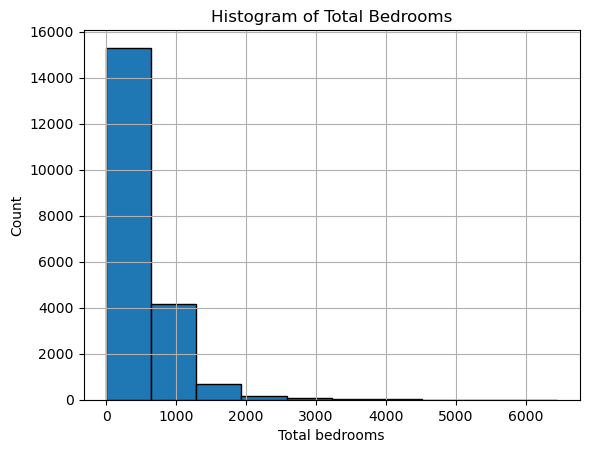

In [9]:
#since we have #total_bedrooms with missing numbers, let check for the data distribution
# Histogram of Total bedroom
california_house_data['total_bedrooms'].hist(bins=10, edgecolor='black')
plt.title("Histogram of Total Bedrooms")
plt.xlabel("Total bedrooms")
plt.ylabel("Count")
plt.show()

Since #total_bedroom is a skewed distribution data, we can use median to fill in the missing data

In [10]:
# Separate features and target
X = california_house_data.drop("median_house_value", axis=1)
y = california_house_data["median_house_value"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types
numerical_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # Fill missing with median
    ("scaler", StandardScaler())                   # Scale features
])
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Fill missing with mode
    ("onehot", OneHotEncoder(handle_unknown="ignore"))     # Convert to dummy vars
])

# Combine preprocessors
preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# Full pipeline: preprocessing + model
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Fit model
model.fit(X_train,y_train)

#Predict
y_pred = model.predict(X_test)  # predictions in log space

# Evaluate
score = model.score(X_test, y_test)
print(f"R² score: {score:.4f}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

#print(f"R² score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

R² score: 0.6254
RMSE: 70059.19


In [11]:
# Your Pipeline for XGBoost Regressor


# Separate features and target
X = california_house_data.drop("median_house_value", axis=1)
y = california_house_data["median_house_value"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns


# Example num pipeline
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", RobustScaler())
])

# Example cat pipeline
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

# Final pipeline with XGBoost
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])


In [12]:
#Train & Evaluate

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Fit model
xgb_pipeline.fit(X_train, y_train)

# Predict
y_pred = xgb_pipeline.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")


R² score: 0.8389
RMSE: 45942.13


In [13]:
# Save
joblib.dump(xgb_pipeline, "house_model.joblib")

# Load
loaded_pipeline = joblib.load("house_model.joblib")

joblib.dump(xgb_pipeline, "housing_model.pkl")

['housing_model.pkl']